### 1. 특징 추출을 위해 사전 훈련된 모델 사용하기: 

- 이미 학습된 모델가져오기
- 필요에 따라 수정하고 마지막 층 추가
- 기존 모델 동결 후 학습
- 그래프로 비교

### 2. 사전 훈련된 모델을 미세 조정(finetuning)하기: 
- 기존 모델 일부 또는 전부 동결 해제(100개 층만 동결)
- 학습
- 1, 2 그래프로 비교

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL 
import tensorflow as tf
import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from google.colab import drive 
import zipfile as zf

In [2]:
drive.mount('/gdrive') # 구글드라이브 연결 

Mounted at /gdrive


In [3]:
files = zf.ZipFile("/gdrive/My Drive/Colab Notebooks/data_15_new.zip",'r') # 압축 파일의 자료 읽기
files.extractall()
files.close()

In [4]:
train_dir = '/content/data_new/train/'
val_dir = '/content/data_new/val/'
test_dir = '/content/data_new/test/'

batch_size = 16
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  #seed=123,
  image_size= IMG_SIZE, 
  batch_size=batch_size)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
  val_dir,
  #seed=123,
  image_size=IMG_SIZE,
  batch_size=batch_size)

test_dataset = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  #seed=123,
  image_size=IMG_SIZE,
  batch_size=batch_size)

class_names = train_dataset.class_names
num_classes = len(class_names)

Found 64000 files belonging to 15 classes.
Found 8000 files belonging to 15 classes.
Found 8000 files belonging to 15 classes.


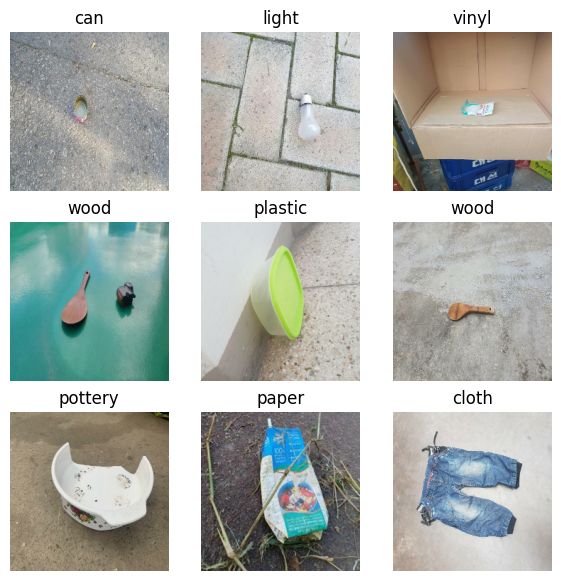

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(7, 7))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    

In [6]:
AUTOTUNE = tf.data.AUTOTUNE  # buffered prefecthing을 사용해 I/O에 막힘 없이 이미지를 디스크에서 읽어올 수 있도록 한다.

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
data_augmentation = tf.keras.Sequential([ #data augmentation ->  model.fit에만 적용
  tf.keras.layers.RandomCrop(224,224),
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),  
])

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input # 모델 다운로드

rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1) # 픽셀 값을 [0, 255]에서 [-1, 1]로 다시 조정


IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, # 맨 위 분류층 제외
                                               weights='imagenet')
 # 이미지를 특징 블록으로 변환
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)

base_model.trainable = False # 주어진 레이어의 가중치가 훈련 중에 업데이트되는 것을 방지 (Trainable params: 0) 

global_average_layer = tf.keras.layers.GlobalAveragePooling2D() # 아웃풋에 풀링을 적용, 5x5 공간 위치에 대한 평균을 구하기
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape) #  공간 위치에 대한 평균을 구하기

prediction_layer = tf.keras.layers.Dense(num_classes) # 특성을 이미지당 단일 예측으로 변환
prediction_batch = prediction_layer(feature_batch_average) #
base_model.summary() # 기존 구조 확인

9406464/9406464 [==============================] - 0s 0us/step
(16, 1280)
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
     

In [8]:
inputs = tf.keras.Input(shape=(224, 224, 3)) #  데이터 증강, 크기 조정, base_model 및 특성 추출기 레이어를 연결해 하나의 모델 만들기
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# 모델을 훈련시키기 전에 컴파일
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

base_model.summary() # 변경한 구조 확인

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [9]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

500/500 [==============================] - 30s 55ms/step - loss: 3.0693 - accuracy: 0.1019


In [10]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
4000/4000 [==============================] - 302s 74ms/step - loss: 1.2162 - accuracy: 0.6158 - val_loss: 0.7706 - val_accuracy: 0.7585
Epoch 2/10
4000/4000 [==============================] - 285s 71ms/step - loss: 0.8036 - accuracy: 0.7409 - val_loss: 0.6718 - val_accuracy: 0.7865
Epoch 3/10
4000/4000 [==============================] - 282s 70ms/step - loss: 0.7317 - accuracy: 0.7632 - val_loss: 0.6358 - val_accuracy: 0.7979
Epoch 4/10
4000/4000 [==============================] - 283s 70ms/step - loss: 0.6968 - accuracy: 0.7749 - val_loss: 0.6120 - val_accuracy: 0.8039
Epoch 5/10
4000/4000 [==============================] - 283s 71ms/step - loss: 0.6705 - accuracy: 0.7824 - val_loss: 0.5920 - val_accuracy: 0.8112
Epoch 6/10
4000/4000 [==============================] - 285s 71ms/step - loss: 0.6520 - accuracy: 0.7890 - val_loss: 0.5839 - val_accuracy: 0.8136
Epoch 7/10
4000/4000 [==============================] - 280s 70ms/step - loss: 0.6420 - accuracy: 0.7920 - val_loss: 0

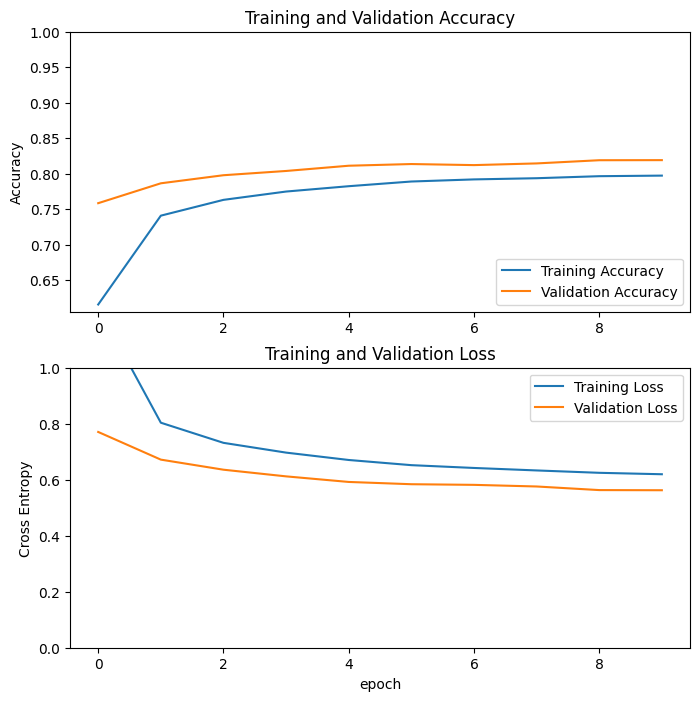

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

미세조정 : 상단 레이어를 함께 fine-tuning하면 모델 퍼포먼스를 향상

In [12]:
base_model.trainable = True


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# 154개의 층
print("Number of layers in the base model: ", len(base_model.layers))

# base_model의 파라미터들을 학습 가능하도록 하고, 밑에서부터 N(=100)개의 레이어만 고정
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

# 학습된 weight에 이어서 학습을 진행 -> 과대적합을 막기 위해 낮은 학습률 사용
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])

Number of layers in the base model:  154


In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [15]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
4000/4000 [==============================] - 370s 88ms/step - loss: 0.5468 - accuracy: 0.8219 - val_loss: 0.4690 - val_accuracy: 0.8482
Epoch 11/20
4000/4000 [==============================] - 296s 74ms/step - loss: 0.4463 - accuracy: 0.8534 - val_loss: 0.4260 - val_accuracy: 0.8640
Epoch 12/20
4000/4000 [==============================] - 310s 77ms/step - loss: 0.3920 - accuracy: 0.8710 - val_loss: 0.3827 - val_accuracy: 0.8736
Epoch 13/20
4000/4000 [==============================] - 313s 78ms/step - loss: 0.3506 - accuracy: 0.8833 - val_loss: 0.3952 - val_accuracy: 0.8712
Epoch 14/20
4000/4000 [==============================] - 299s 75ms/step - loss: 0.3234 - accuracy: 0.8927 - val_loss: 0.3538 - val_accuracy: 0.8874
Epoch 15/20
4000/4000 [==============================] - 313s 78ms/step - loss: 0.2951 - accuracy: 0.9023 - val_loss: 0.3438 - val_accuracy: 0.8894
Epoch 16/20
4000/4000 [==============================] - 310s 77ms/step - loss: 0.2787 - accuracy: 0.9069 - val_

In [16]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

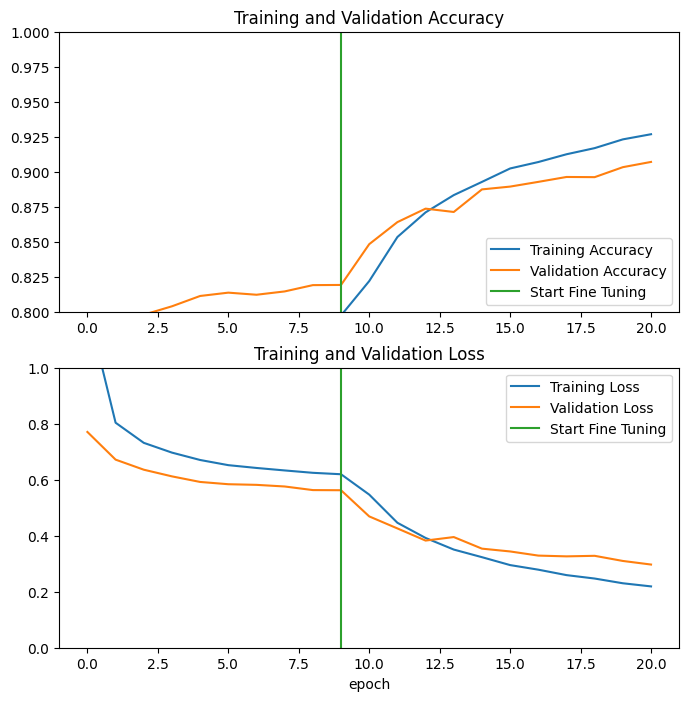

In [17]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [18]:
loss, accuracy = model.evaluate(test_dataset)# 테스트 데이터셋으로 예측해보기
print('Test accuracy :', accuracy)

500/500 [==============================] - 30s 59ms/step - loss: 0.2891 - accuracy: 0.9109
Test accuracy : 0.9108750224113464


In [20]:
model.save('model.h5') # 모델 통채로 저장